In [1]:
%reload_ext autoreload
%autoreload 2

from transformers import (
    BitsAndBytesConfig,
    LlavaNextProcessor,
    LlavaNextForConditionalGeneration
)
from PIL import Image, ImageOps
import torch
import pandas as pd
import re
import gc
from tqdm import tqdm
import os
import random
from pathlib import Path
import matplotlib.pyplot as plt
import ast

from test_MLLMs import mllm_testing, run_vlm_evaluation
from making_color_images.model_priors import ModelColorPriors

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

fontsize = 14

In [2]:
# Base data folder
WORK = Path(os.environ.get("WORK", Path.cwd()))
data_folder = WORK / "color-concept-entanglement" / "data"

fruit = data_folder / "fruit"
color_outlines = data_folder / "color_images"

## Load Model

In [3]:
# Set a specific seed for reproducibility
SEED = 42

# Setting the seed for PyTorch
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # If using GPU

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    llm_int8_enable_fp32_cpu_offload=True
)

processor = LlavaNextProcessor.from_pretrained("llava-hf/llava-v1.6-mistral-7b-hf")
model = LlavaNextForConditionalGeneration.from_pretrained(
    "llava-hf/llava-v1.6-mistral-7b-hf", dtype=torch.float16, low_cpu_mem_usage=True, device_map="auto", quantization_config=bnb_config
).to(device)

Using device: cuda


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

## 1. Simple Fruit Dataset

In [ ]:
# Simple fruit dataset
evaluate_fruit = True
df = pd.read_parquet(fruit/ "fruit_images.parquet")

if evaluate_fruit:
    df_results = run_vlm_evaluation(
        df,
        processor,
        model,
        device,
        mode="both"
    )
    
    display(df_results)
    out_path = fruit / "outline_results.csv"
    df.to_csv(out_path, index=False)
elif (fruit / "outline_results.csv").exists():
    fruit_df = pd.read_csv(fruit / "outline_results.csv")
    display(fruit_df)

Running VLM (both): 100%|██████████| 30/30 [03:40<00:00,  7.35s/it]


,object,image_type,image_path,pred_color_most,pred_color_this
0,banana,grayscale,data/fruit/banana1.jpeg,yellow,yellow
1,banana,background,data/fruit/banana1_background.jpeg,yellow,white
2,banana,color,data/fruit/banana1_color.jpeg,yellow,yellow
3,banana,grayscale,data/fruit/banana2.jpeg,yellow,black
4,banana,background,data/fruit/banana2_background.jpeg,yellow,white
5,banana,color,data/fruit/banana2_color.jpeg,yellow,yellow
6,blueberry,grayscale,data/fruit/blueberry.jpeg,white,white
7,blueberry,background,data/fruit/blueberry_background.jpeg,white,white
8,blueberry,color,data/fruit/blueberry_color.jpeg,blue,blue
9,cucumber,grayscale,data/fruit/cucumber.jpeg,green,white


## 2. Outline Image Dataset 

In [14]:
df = pd.read_csv(data_folder / "colored_images.csv")
display(df)

,correct_answer,incorrect_answer,object,image_url,image_path,gpt_response,score,watermark,num_objects,cv_mask_path,sam_mask_path
0,"['grey', 'black']",red,Norwegian elkhound,https://t3.ftcdn.net/jpg/16/85/30/00/360_F_168...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
1,"['black', 'brown']",pink,Newfoundland,https://fydn.imgix.net/m%2Fgen%2Fart-print-std...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
2,['red'],yellow,lobster,https://media.istockphoto.com/id/848729864/vec...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
3,"['grey', 'black']",brown,car wheel,https://www.shutterstock.com/image-illustratio...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
4,['green'],red,bullfrog,https://media.istockphoto.com/id/964986066/vec...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
...,...,...,...,...,...,...,...,...,...,...,...
350,"['brown', 'green']",blue,beer bottle,https://c8.alamy.com/comp/2XF01E0/hand-drawn-b...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",23.0,True,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
351,['green'],purple,parakeet,https://cdn.vectorstock.com/i/1000v/43/67/blac...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",23.0,True,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
352,['green'],blue,lawn_mower,https://i.etsystatic.com/35917727/r/il/6615c3/...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",23.0,True,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
353,['yellow'],purple,lemon,https://i.pinimg.com/474x/14/b7/8c/14b78c7fe1c...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",23.0,True,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...


## 2.1. Query world-knowledge color priors

In [15]:
# Select specific objects for testing
df = pd.read_csv(data_folder / "colored_images.csv")
#df = df[df["object"].isin(["bullfrog", "pig", "king crab", "tick", "Norwegian elkhound", "beets"])]
display(df)

,correct_answer,incorrect_answer,object,image_url,image_path,gpt_response,score,watermark,num_objects,cv_mask_path,sam_mask_path
0,"['grey', 'black']",red,Norwegian elkhound,https://t3.ftcdn.net/jpg/16/85/30/00/360_F_168...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
1,"['black', 'brown']",pink,Newfoundland,https://fydn.imgix.net/m%2Fgen%2Fart-print-std...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
2,['red'],yellow,lobster,https://media.istockphoto.com/id/848729864/vec...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
3,"['grey', 'black']",brown,car wheel,https://www.shutterstock.com/image-illustratio...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
4,['green'],red,bullfrog,https://media.istockphoto.com/id/964986066/vec...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
...,...,...,...,...,...,...,...,...,...,...,...
350,"['brown', 'green']",blue,beer bottle,https://c8.alamy.com/comp/2XF01E0/hand-drawn-b...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",23.0,True,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
351,['green'],purple,parakeet,https://cdn.vectorstock.com/i/1000v/43/67/blac...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",23.0,True,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
352,['green'],blue,lawn_mower,https://i.etsystatic.com/35917727/r/il/6615c3/...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",23.0,True,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
353,['yellow'],purple,lemon,https://i.pinimg.com/474x/14/b7/8c/14b78c7fe1c...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",23.0,True,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...


In [19]:
priors = ModelColorPriors(
    processor=processor,
    model=model,
    data_folder=data_folder,
    device=device
)

# Generate new priors
ground_truth_df = priors.get_model_color_priors(df)

Running model color priors:   0%|          | 0/355 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [20]:
# Checkpoint: display the generated priors
ground_truth_df = pd.read_csv(data_folder / "model_color_priors.csv")
display(ground_truth_df[['object', 'correct_answer', 'model_prior_dummy', 'model_prior']])

,object,correct_answer,model_prior_dummy,model_prior
0,Norwegian elkhound,"['grey', 'black']",grey,grey
1,Newfoundland,"['black', 'brown']",black,black
2,lobster,['red'],red,red
3,car wheel,"['grey', 'black']",black,black
4,bullfrog,['green'],green,green
...,...,...,...,...
350,beer bottle,"['brown', 'green']",green,green
351,parakeet,['green'],green,green
352,lawn_mower,['green'],green,green
353,lemon,['yellow'],yellow,yellow


In [21]:
# Analyze dummy vs real
ground_truth_df = priors.analyze_differences(ground_truth_df)

0 rows differ between dummy and real priors.
101 rows where model color prior NOT in ground truth.
Model color priors: ['grey' 'black' 'red' 'green' 'yellow' 'orange' 'white' 'brown' 'silver'
 'blue' 'pink' 'purple' 'gold' 'clear']


In [22]:
# Replace correct_answer in main df with model priors
df_updated = priors.replace_correct_answers(df, ground_truth_df)

Excluding colors: ['silver', 'gold', 'white', 'clear']
Updated dataset now has 299 rows.


In [ ]:
# Save or load
# ground_truth_df = priors.load_model_priors()

In [24]:
def normalize_colors(c):
    """Return a list of color strings from string or list-like entries."""
    if c is None:
        return []
    if isinstance(c, str):
        return [c.strip().lower()]
    try:
        return [str(x).strip().lower() for x in c if str(x).strip()]
    except Exception:
        return [str(c).strip().lower()]

def _variant_sort_key(p: Path):
    name = p.name
    m_fg = re.match(r"FG_(\d{3})\.png$", name)
    if m_fg:
        return (0, int(m_fg.group(1)))
    m_bg = re.match(r"BG_(\d{3})\.png$", name)
    if m_bg:
        return (1, int(m_bg.group(1)))
    return (9, name)

def collect_variants_for(image_path: str, target_color: str, out_root: Path = color_outlines):
    stem = Path(image_path).stem
    color_dir = out_root / f"{stem}_{target_color}"

    if not color_dir.exists():
        return []

    fg = list(color_dir.glob("FG_*.png"))
    bg = list(color_dir.glob("BG_*.png"))

    paths = fg + bg
    return sorted(paths, key=_variant_sort_key)

def show_variants_grid(image_path: str, target_color: str, out_root: Path = color_outlines, thumb_w: int = 256):
    """
    Display a 2-row grid:
      Row 1: FG 0..100% (11 images)
      Row 2: BG 10..100% (10 images), shifted right by 1 so both rows end in the same column.
    """
    paths = collect_variants_for(image_path, target_color, out_root)
    if not paths:
        print(f"No variants found for {image_path}")
        return

    # Split into 11 + 10 (by filename pattern)
    fg_paths = [p for p in paths if "FG_" in p.name]   # 11
    bg_paths = [p for p in paths if "BG_" in p.name]   # 10

    cols = len(fg_paths)
    rows = 2
    fig_w = cols * (thumb_w / 100)  # ~100 px ≈ 1 inch
    fig, axes = plt.subplots(rows, cols, figsize=(fig_w, rows * 2.8))

    # Normalize axes to 2 x cols
    if rows == 1:
        axes = [axes]
    if cols == 1:
        axes = [[axes[0]], [axes[1]]]

    def _draw_row(ax_row, paths_row, title_prefix, start_col=0):
      for c in range(cols):
          ax = ax_row[c]
          ax.axis("off")
          idx = c - start_col
          if 0 <= idx < len(paths_row):
              p = paths_row[idx]
              im = Image.open(p).convert("RGB")
              ax.imshow(im)
              m = re.search(r"(\d{3})(?=\.png$)", p.name)
              pct = int(m.group(1)) if m else ""
              ax.set_title(f"{title_prefix} {pct}%", fontsize=fontsize)

    _draw_row(axes[0], fg_paths, "FG", start_col=0)  # 11 images
    _draw_row(axes[1], bg_paths, "BG", start_col=1)  # shift BG right by 1 (first slot empty)

    fig.suptitle(f"{Path(image_path).name} - {target_color}", fontsize=fontsize)
    plt.tight_layout()
    plt.show()

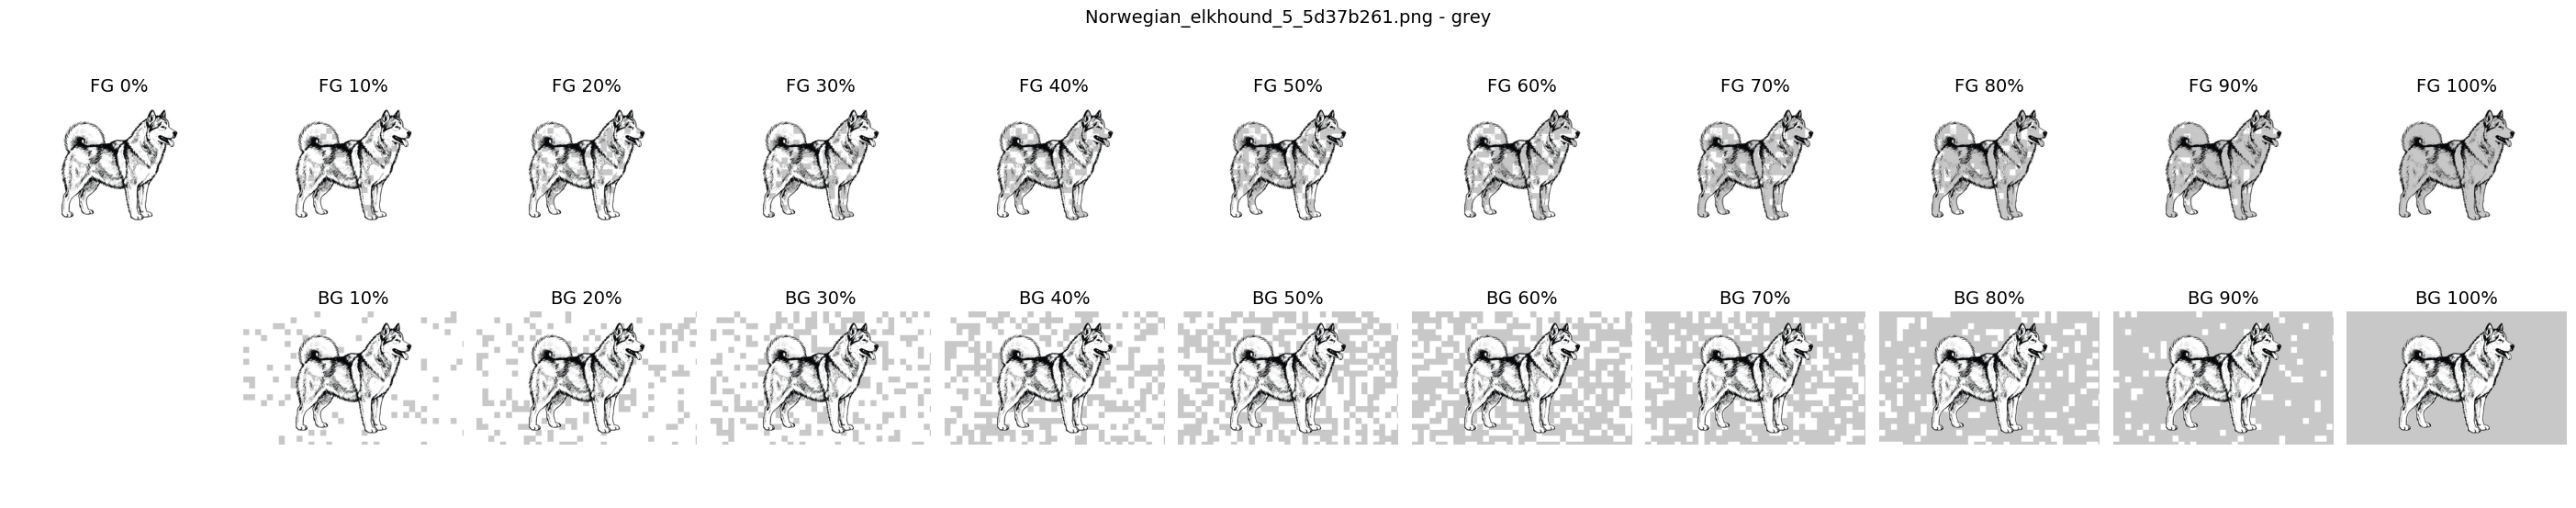

No variants found for /mnt/lustre/work/eickhoff/esx061/color-concept-entanglement/data/norm_outline_images/Norwegian_elkhound_5_5d37b261.png
No variants found for /mnt/lustre/work/eickhoff/esx061/color-concept-entanglement/data/norm_outline_images/Newfoundland_1_48a10bf6.png
No variants found for /mnt/lustre/work/eickhoff/esx061/color-concept-entanglement/data/norm_outline_images/Newfoundland_1_48a10bf6.png
No variants found for /mnt/lustre/work/eickhoff/esx061/color-concept-entanglement/data/norm_outline_images/lobster_5_2bf42fc8.png
No variants found for /mnt/lustre/work/eickhoff/esx061/color-concept-entanglement/data/norm_outline_images/car_wheel_2_0f5627b5.png
No variants found for /mnt/lustre/work/eickhoff/esx061/color-concept-entanglement/data/norm_outline_images/car_wheel_2_0f5627b5.png


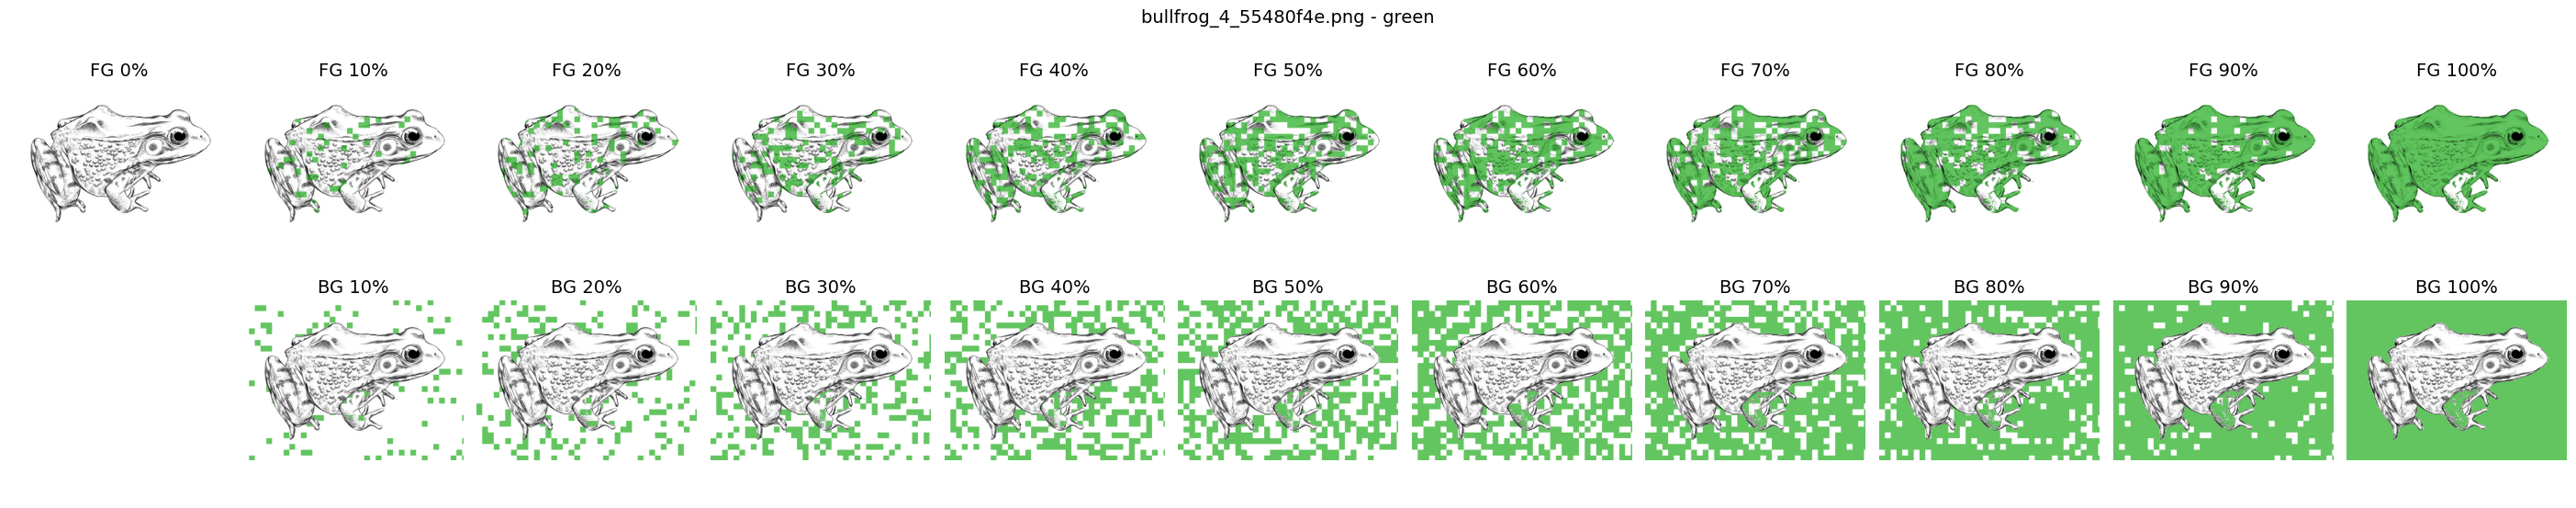

In [ ]:
for idx, row in df.head().iterrows():
    target_colors = ast.literal_eval(row['correct_answer'])
    for tcol in target_colors:
        show_variants_grid(row['image_path'], tcol)

In [29]:
df = df[df["object"] == "bullfrog"]

In [30]:
def variant_label(p: Path):
    """
    Create readable labels from variant filenames (FG_###.png / BG_###.png / base).
    """
    name = p.name
    if "FG_" in name:
        m = re.search(r"FG_(\d{3})", name)
        return f"FG {int(m.group(1))}%" if m else "FG"
    elif "BG_" in name:
        m = re.search(r"BG_(\d{3})", name)
        return f"BG {int(m.group(1))}%" if m else "BG"
    else:
        return "white"


# Main evaluation of color outline variants
outline_results = []

print("Running outline variant evaluation...")

for _, row in tqdm(df.iterrows(), total=len(df), desc="Evaluating objects"):
    image_path = row["image_path"]
    object_name = row["object"]
    target_colors = ast.literal_eval(row["correct_answer"])

    for target_color in target_colors:
        # Collect all variant image paths for this color
        variants = collect_variants_for(image_path, target_color, out_root=color_outlines)
        if not variants:
            continue

        # Build a dataframe for all variants of this image
        df_variants = pd.DataFrame({
            "image_path": [str(p) for p in variants],
            "image_variant": [variant_label(p) for p in variants],
            "object": [object_name] * len(variants),
            "correct_answer": [target_color] * len(variants),
            "image_type": ["variant"] * len(variants),
        })

        # Run both "most" and "this" question types on all variants
        df_eval = run_vlm_evaluation(
            df=df_variants,
            processor=processor,
            model=model,
            device=device,
            batch_size=1,
            mode="both"   
        )
        
        df_eval = df_eval[["object", "image_variant", "correct_answer", "pred_color_most", "pred_color_this"]]
        outline_results.append(df_eval)

        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
        gc.collect()

df_outline = pd.concat(outline_results, ignore_index=True)

out_path = data_folder / "outline_results.csv"
df_outline.to_csv(out_path, index=False)
print(f"Saved combined outline evaluation results to {out_path}")
display(df_outline.head())


Running outline variant evaluation...


Evaluating objects:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating objects:   0%|          | 0/1 [02:39<?, ?it/s]


KeyError: "['image_variant', 'correct_answer'] not in index"

In [ ]:
def variant_label(p: Path):
    name = p.name
    if "FG_" in name:
        m = re.search(r"FG_(\d{3})", name)
        return f"FG {int(m.group(1))}%" if m else "FG"
    elif "BG_" in name:
        m = re.search(r"BG_(\d{3})", name)
        return f"BG {int(m.group(1))}%" if m else "BG"
    else:
        return "white"


# --- Main evaluation ---
outline_results = []

for _, row in tqdm(df.iterrows(), total=len(df)):
    image_path = row["image_path"]
    target_colors = ast.literal_eval(row["correct_answer"])
    object_name = row["object"]

    for target_color in target_colors:
        variants = collect_variants_for(image_path, target_color, out_root=color_outlines)
        if not variants:
            continue

        df_variants = pd.DataFrame({
            "image_path": [str(p) for p in variants],
            "image_variant": [variant_label(p) for p in variants],
            "object": [object_name] * len(variants),
            "correct_answer": [target_color] * len(variants)
        })

        df_most = mllm_testing(df_variants, processor, model, most="True")
        df_most = df_most.rename(columns={"predicted_color": "pred_color_most"})

        df_this = mllm_testing(df_variants, processor, model, most="False")
        df_this = df_this.rename(columns={"predicted_color": "pred_color_this"})

        merged = pd.merge(
            df_most,
            df_this,
            on=["image_path","image_variant", "object", "correct_answer"]
        )

        outline_results.append(merged)

        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
        gc.collect()

df_outline = pd.concat(outline_results, ignore_index=True)
df_outline = df_outline[["object", "image_variant", "correct_answer", "pred_color_most", "pred_color_this"]]
out_path = data_folder / "outline_results.csv"
df_outline.to_csv(out_path, index=False)
print(f"Saved combined outline evaluation results to {out_path}")

100%|██████████| 355/355 [05:03<00:00,  1.17it/s]

Saved combined outline evaluation results to /mnt/lustre/work/eickhoff/esx061/color-concept-entanglement/data/outline_results.csv


In [ ]:
df_outline[df_outline['object'] == 'king crab']

,object,image_variant,correct_answer,pred_color_most,pred_color_this
147,king crab,FG 0%,orange,red,red
148,king crab,FG 10%,orange,red,red
149,king crab,FG 20%,orange,red,red
150,king crab,FG 30%,orange,red,red
151,king crab,FG 40%,orange,red,red
152,king crab,FG 50%,orange,red,red
153,king crab,FG 60%,orange,red,red
154,king crab,FG 70%,orange,red,red
155,king crab,FG 80%,orange,red,red
156,king crab,FG 90%,orange,red,red


In [ ]:
def show_variants_grid_with_predictions(
    df_outline: pd.DataFrame,
    image_path: str,
    target_color: str,
    out_root: Path = color_outlines,
    question: str = "this",       # "this" or "most"
    thumb_w: int = 256,         
    row_h: float = 3.5
):
    """
    Display a 2-row grid of variants for a given image and color target,
    showing the model's predicted color under each image.
    """

    pred_col = "pred_color_this" if question.lower() == "this" else "pred_color_most"

    paths = collect_variants_for(image_path, target_color, out_root)
    if not paths:
        print(f"No variants found for {image_path}")
        return

    fg_paths = [p for p in paths if "FG_" in p.name]
    bg_paths = [p for p in paths if "BG_" in p.name]

    cols = len(fg_paths)
    rows = 2

    # Scale figure width 
    fig_w = cols * (thumb_w / 80)   # was /100, now larger
    fig_h = rows * row_h
    fig, axes = plt.subplots(rows, cols, figsize=(fig_w, fig_h))

    # Normalize axes array
    if rows == 1:
        axes = [axes]
    if cols == 1:
        axes = [[axes[0]], [axes[1]]]

    def get_prediction(label):
        match = df_outline[
            (df_outline["image_variant"].str.lower() == label.lower())
            & (df_outline["correct_answer"].str.lower() == target_color.lower())
        ]
        if not match.empty and pred_col in match.columns:
            return str(match.iloc[0][pred_col])
        return "—"

    def _draw_row(ax_row, paths_row, title_prefix, start_col=0):
        for c in range(cols):
            ax = ax_row[c]
            ax.axis("off")
            idx = c - start_col
            if 0 <= idx < len(paths_row):
                p = paths_row[idx]
                im = Image.open(p).convert("RGB")
                ax.imshow(im)

                m = re.search(r"(\d{3})(?=\.png$)", p.name)
                pct = int(m.group(1)) if m else ""
                variant_label = f"{title_prefix} {pct}%" if pct != "" else title_prefix
                pred = get_prediction(variant_label)

                ax.set_title(variant_label, fontsize=fontsize, pad=4)
                ax.text(
                    0.5, -0.15, pred,
                    transform=ax.transAxes,
                    ha='center', va='top',
                    fontsize=fontsize,
                    fontweight='bold'
                )

    _draw_row(axes[0], fg_paths, "FG", start_col=0)
    _draw_row(axes[1], bg_paths, "BG", start_col=1)

    fig.suptitle(
        f"{Path(image_path).name} — target: {target_color} ({question})",
        fontsize=fontsize + 4,
        fontweight="bold"
    )

    plt.subplots_adjust(top=0.85, bottom=0.1, hspace=0.4, wspace=0.05)
    plt.show()

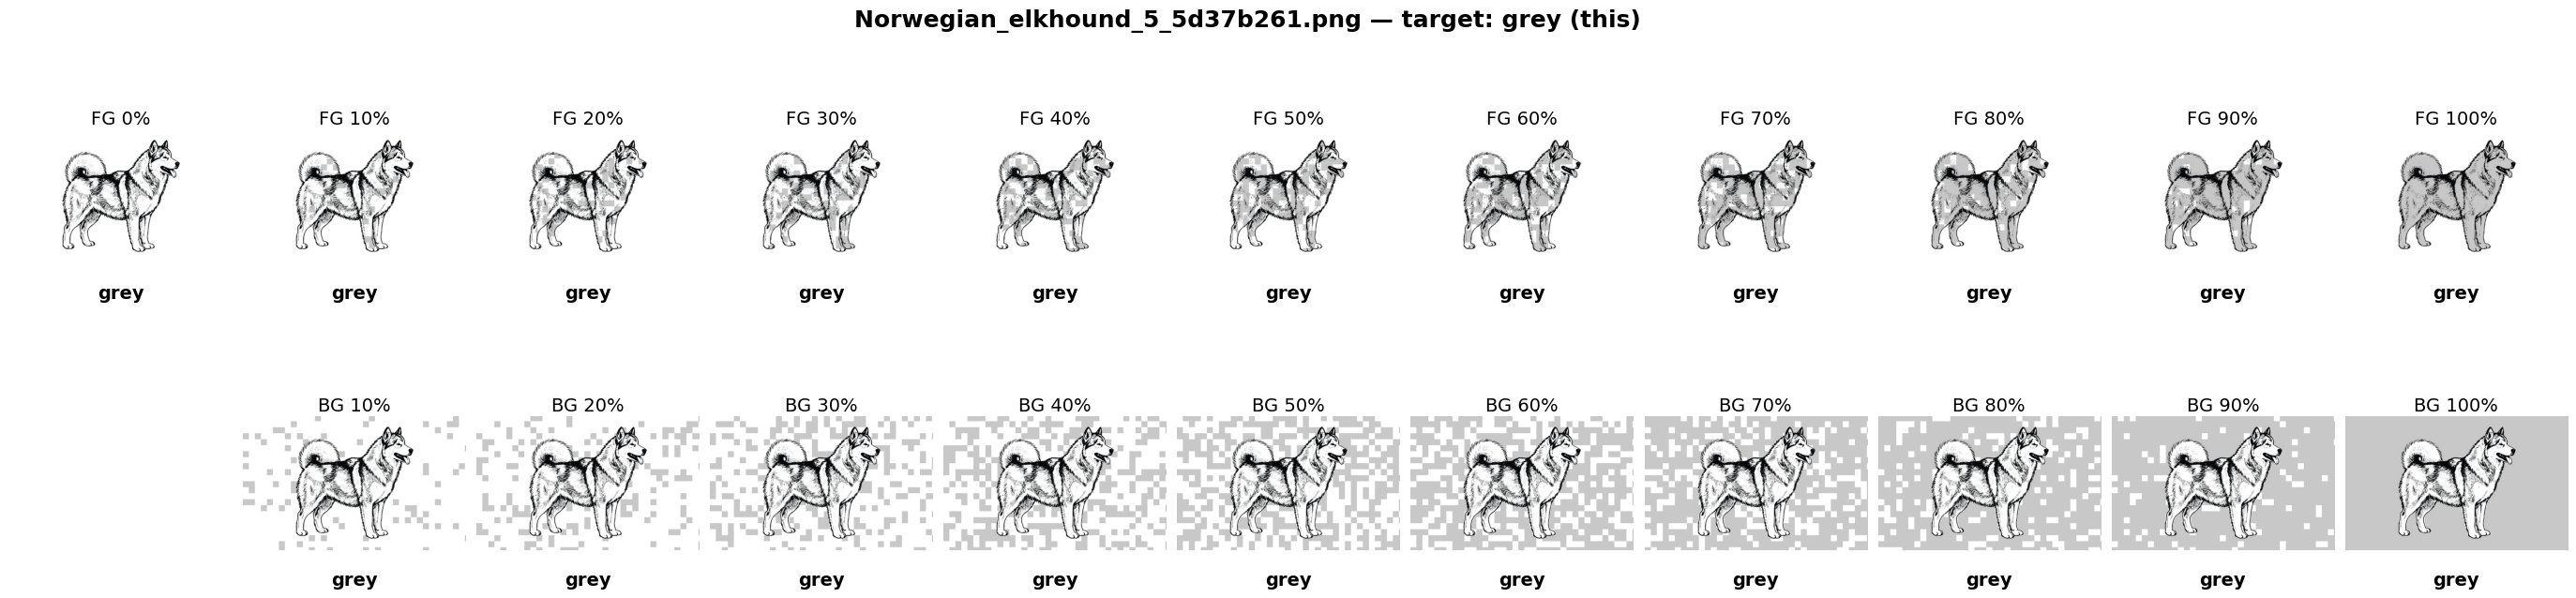

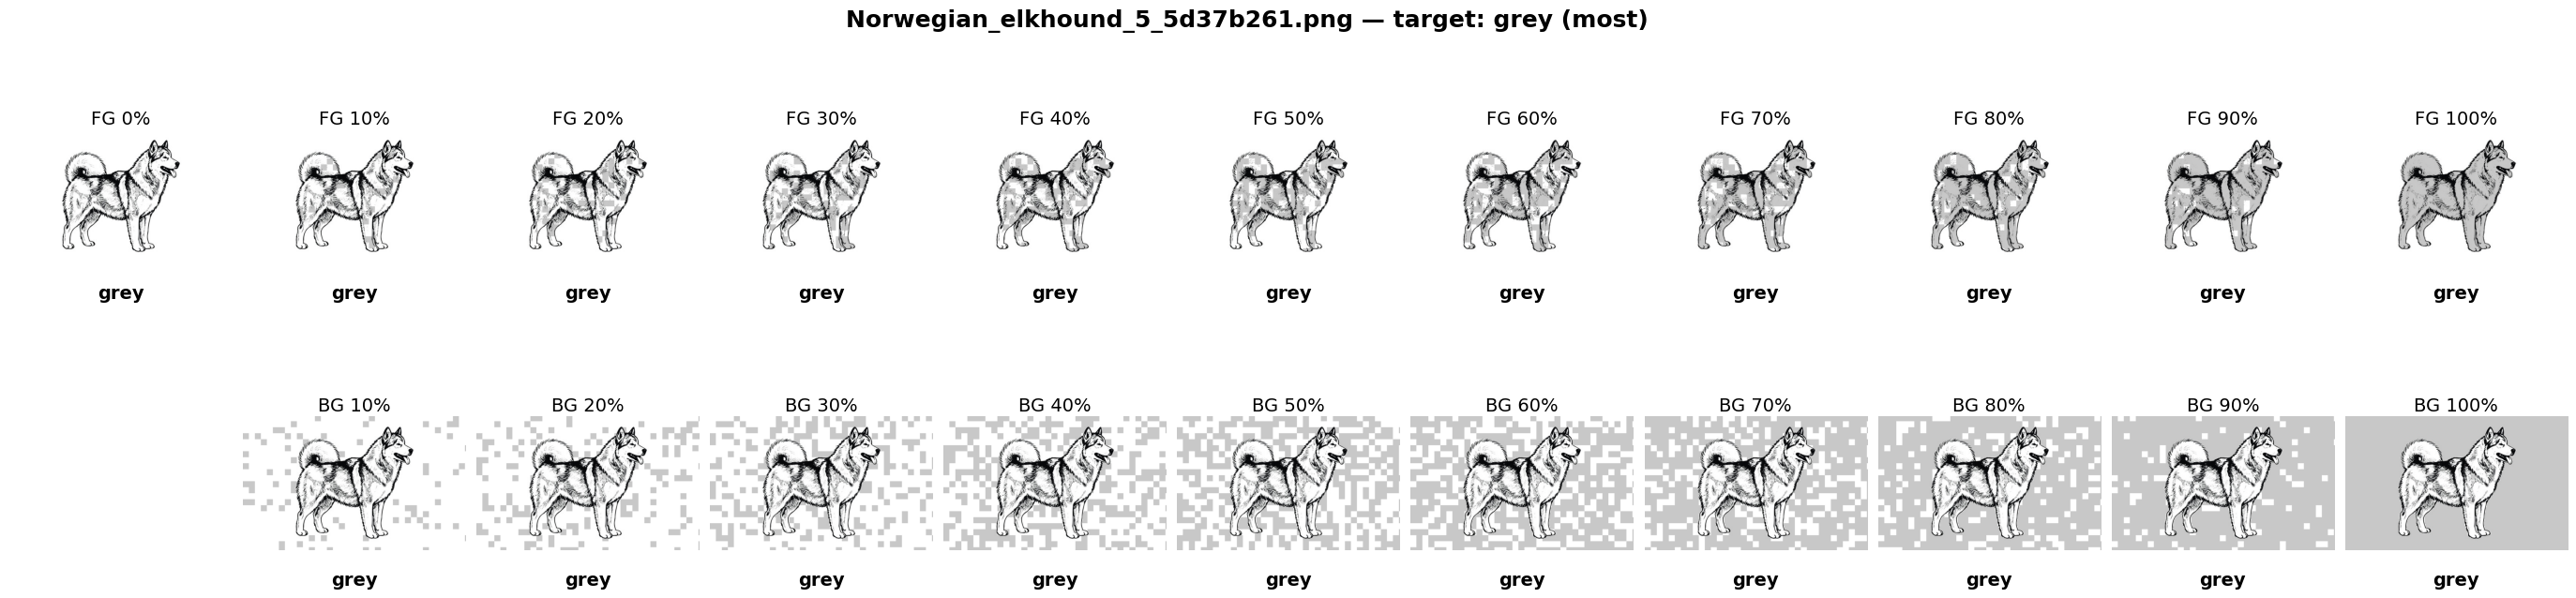

No variants found for /mnt/lustre/work/eickhoff/esx061/color-concept-entanglement/data/norm_outline_images/Norwegian_elkhound_5_5d37b261.png
No variants found for /mnt/lustre/work/eickhoff/esx061/color-concept-entanglement/data/norm_outline_images/Norwegian_elkhound_5_5d37b261.png
No variants found for /mnt/lustre/work/eickhoff/esx061/color-concept-entanglement/data/norm_outline_images/Newfoundland_1_48a10bf6.png
No variants found for /mnt/lustre/work/eickhoff/esx061/color-concept-entanglement/data/norm_outline_images/Newfoundland_1_48a10bf6.png
No variants found for /mnt/lustre/work/eickhoff/esx061/color-concept-entanglement/data/norm_outline_images/Newfoundland_1_48a10bf6.png
No variants found for /mnt/lustre/work/eickhoff/esx061/color-concept-entanglement/data/norm_outline_images/Newfoundland_1_48a10bf6.png
No variants found for /mnt/lustre/work/eickhoff/esx061/color-concept-entanglement/data/norm_outline_images/lobster_5_2bf42fc8.png
No variants found for /mnt/lustre/work/eickhoff/

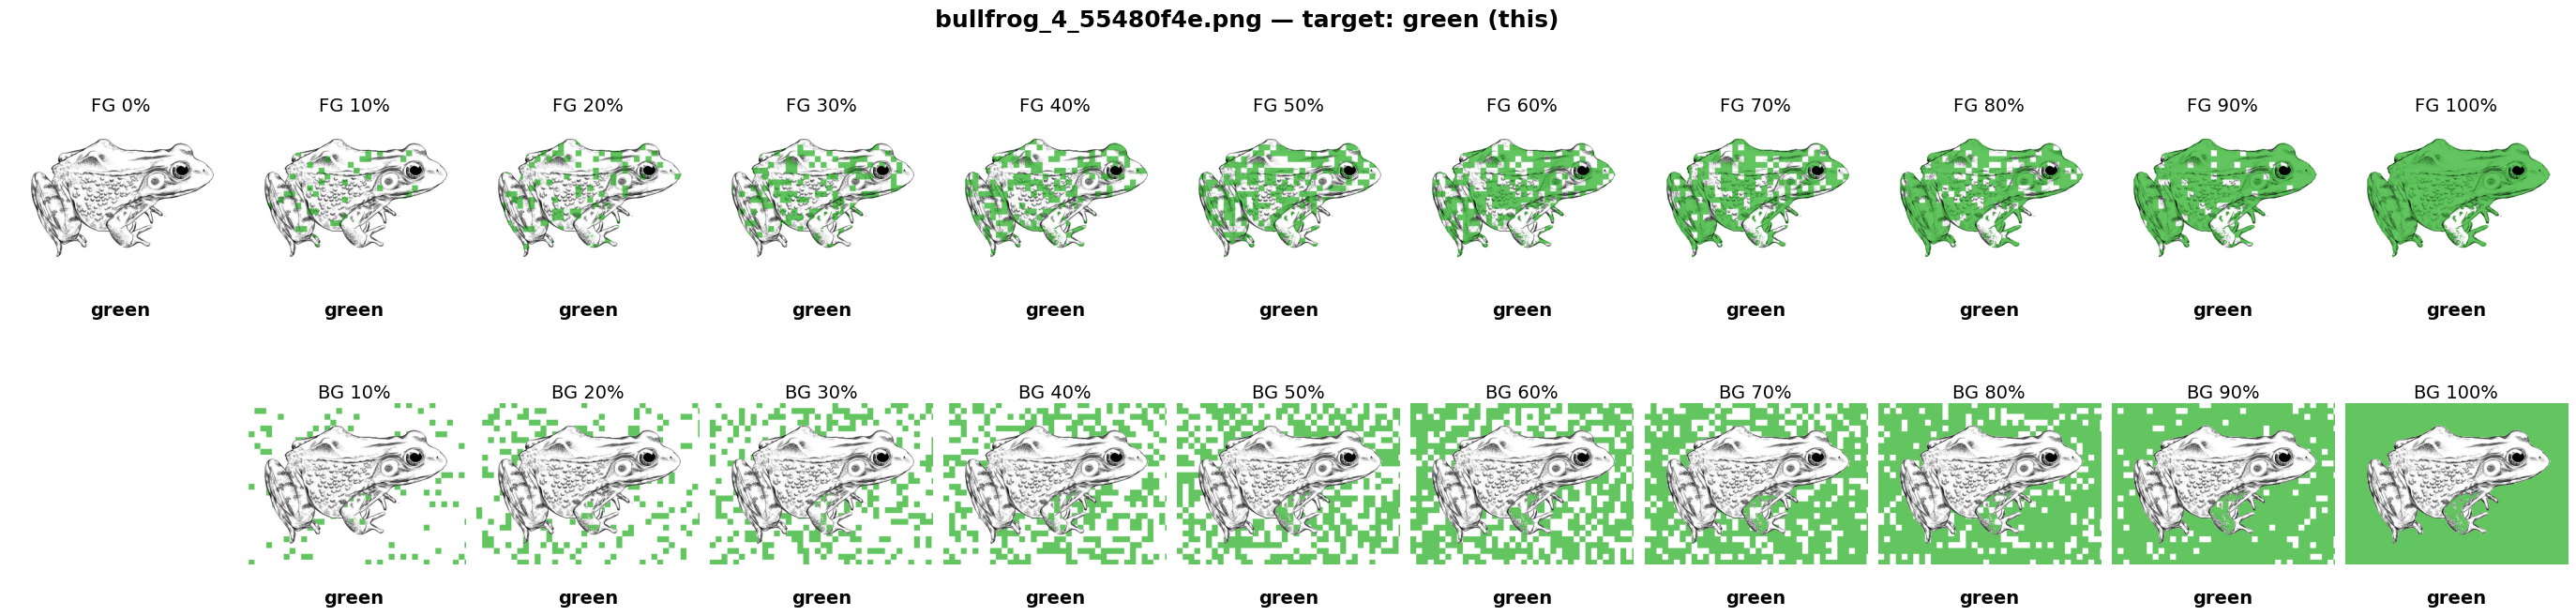

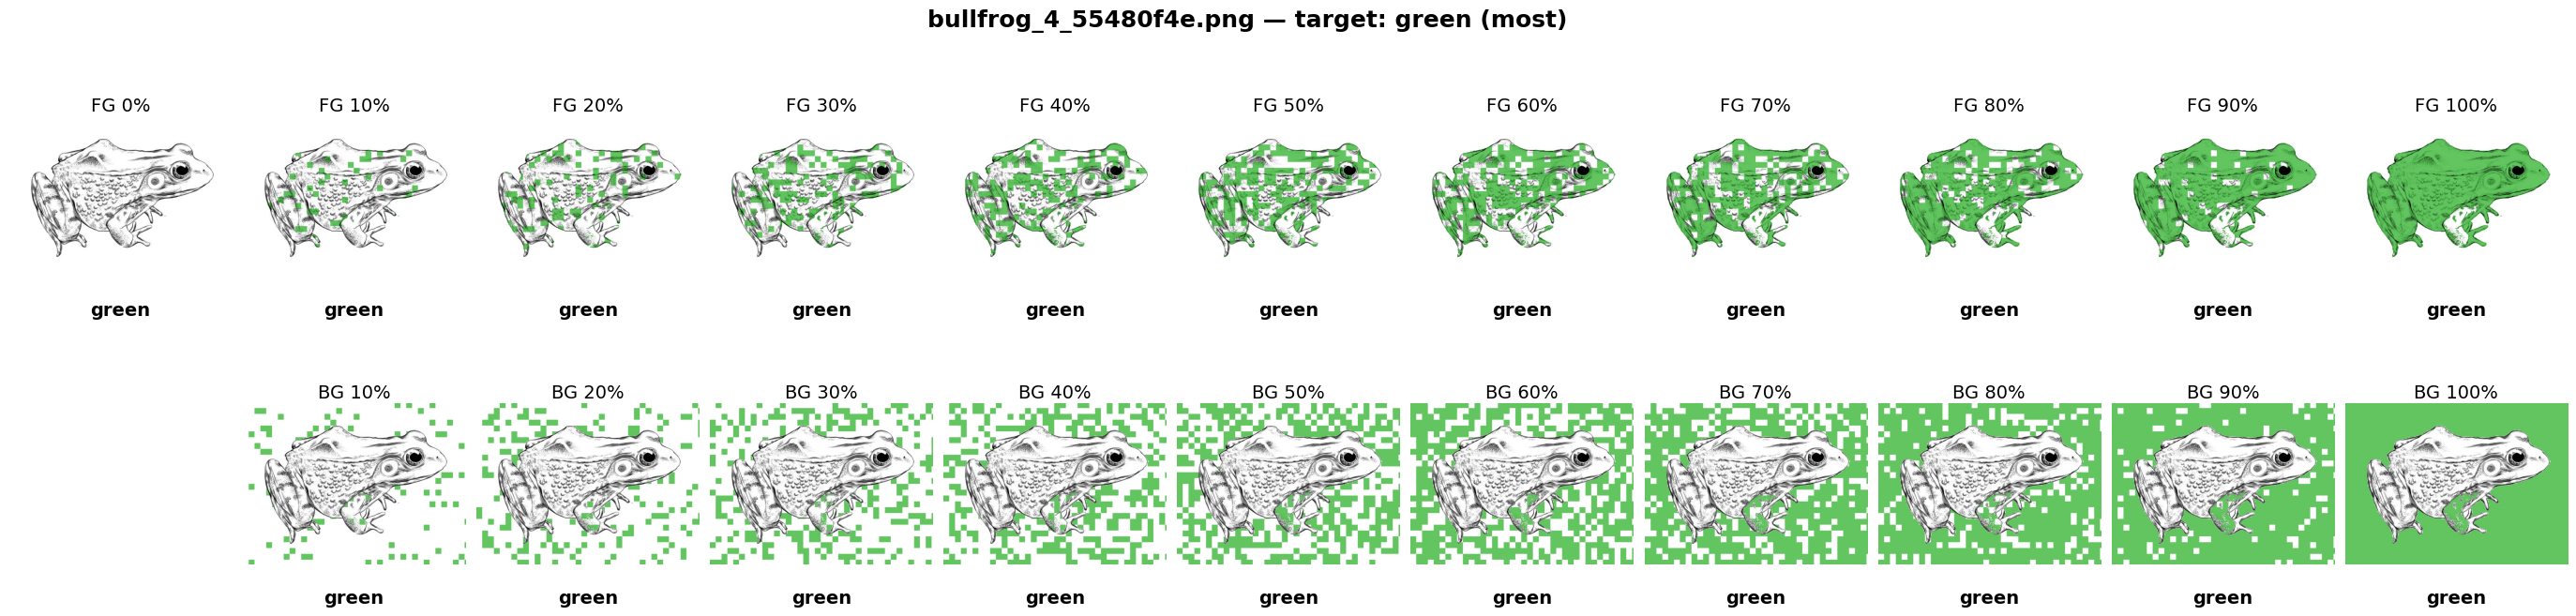

In [ ]:
for idx, row in df.head().iterrows():
    target_colors = ast.literal_eval(row['correct_answer'])
    for tcol in target_colors:
        # Show predictions for both question types
        show_variants_grid_with_predictions(df_outline, row["image_path"], tcol, question="this")
        show_variants_grid_with_predictions(df_outline, row["image_path"], tcol, question="most")